### Compare VAE with VQ-VAE


1. **Discrete Latent Representations:**
   - **VAE:** VAEs use continuous latent representations, which means the latent space is continuous and allows for smooth interpolation between different data points. However, this can make it challenging to model and generate discrete structures in the data.
   - **VQ-VAE:** VQ-VAE introduces a discrete latent space. This is achieved by applying vector quantization to the continuous latent space. The discrete codes enable the model to better capture categorical or symbolic information in the data, making it more suitable for tasks where discrete representations are important.

2. **Improved Representation of Categorical Information:**
   - **VAE:** In a standard VAE, the continuous nature of the latent space may not be optimal for capturing categorical information or representing data with clear boundaries.
   - **VQ-VAE:** By using discrete latent codes, VQ-VAE excels at representing categorical information. It can create distinct codes for different categories, allowing for more faithful reconstruction of categorical features in the generated data.

3. **Enhanced Generative Process:**
   - **VAE:** The continuous latent space in VAEs may result in the generation of samples that exhibit interpolation but may lack clear boundaries between categories.
   - **VQ-VAE:** The discrete latent space encourages the model to generate samples with well-defined categorical boundaries. This is particularly beneficial in scenarios where the data has distinct categories or symbols that need to be accurately captured.

4. **Stable Training and Improved Expressiveness:**
   - **VAE:** Training VAEs can sometimes be challenging due to issues like mode collapse or blurry reconstructions.
   - **VQ-VAE:** The discrete nature of the latent space in VQ-VAE contributes to stable training and can result in more expressive representations. The quantized codes provide a clear structure that helps the model avoid some of the challenges associated with continuous latent spaces.

5. **Applicability to Specific Data Structures:**
   - **VAE:** VAEs are more commonly used for tasks where continuous representations are suitable, such as image generation and data interpolation.
   - **VQ-VAE:** VQ-VAE is particularly well-suited for tasks involving discrete or symbolic data, like text generation or other domains where categorical information is crucial.

In [1]:
# Import required packages
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from torchvision.utils import make_grid
import matplotlib.animation as animation
from PIL import Image

In [2]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training and testing datasets
train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)

# Define batch size
batch_size = 256

# Create data loaders
train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True,
                           pin_memory=True,
                           num_workers=4)

test_loader = DataLoader(test_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 215404799.93it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 83140489.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93255099.00it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(num_residual_hiddens, num_hiddens, kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        # Apply residual connection
        return x + self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.num_residual_layers = num_residual_layers
        # Create a list of residual blocks
        self.layers = nn.ModuleList([ResidualBlock(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self.num_residual_layers)])

    def forward(self, x):
        # Apply the specified number of residual layers
        for layer in self.layers:
            x = layer(x)
        return F.relu(x)

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels, num_hiddens // 2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(num_hiddens // 2, num_hiddens, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(num_hiddens, num_hiddens, kernel_size=3, stride=1, padding=1)

        # Create a residual stack
        self.residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        # Apply convolutional layers with ReLU activation
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Apply the residual stack
        return self.residual_stack(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, data_channels):
        super(Decoder, self).__init__()

        # Define convolutional layer
        self.conv1 = nn.Conv2d(in_channels, num_hiddens, kernel_size=3, stride=1, padding=1)

        # Create a residual stack
        self.residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens)

        # Define transposed convolutional layers
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=num_hiddens, out_channels=num_hiddens // 2, kernel_size=4, stride=2, padding=1)

        self.conv_trans2 = nn.ConvTranspose2d(in_channels=num_hiddens // 2, out_channels=data_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        # Apply convolutional layer
        x = self.conv1(inputs)

        # Apply the residual stack
        x = self.residual_stack(x)

        # Apply transposed convolutional layers with ReLU activation
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)

        return x

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # Define embedding layer
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        # Initialize the embedding weights with uniform values
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        # Permute input dimensions for compatibility (BCHW -> BHWC)
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten the input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances between input and embedding vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Find the indices of the closest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Calculate quantized output
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Calculate latent losses
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Update quantized using straight-through estimator
        quantized = inputs + (quantized - inputs).detach()

        # Calculate perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Return the calculated values
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [7]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # Define embedding layer
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        # Initialize the embedding weights with normal distribution
        self.embedding.weight.data.normal_()

        self.commitment_cost = commitment_cost

        # Exponential Moving Average (EMA) parameters
        self.register_buffer('ema_cluster_size', torch.zeros(num_embeddings))
        self.ema_w = nn.Parameter(torch.Tensor(num_embeddings, self.embedding_dim))
        self.ema_w.data.normal_()

        self.decay = decay
        self.epsilon = epsilon

    def forward(self, inputs):
        # Permute input dimensions for compatibility (BCHW -> BHWC)
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten the input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances between input and embedding vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Find the indices of the closest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Calculate quantized output
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        if self.training:
            # Update EMA cluster size
            self.ema_cluster_size = self.ema_cluster_size * self.decay + (1 - self.decay) * torch.sum(encodings, 0)

            n = torch.sum(self.ema_cluster_size.data)
            self.ema_cluster_size = ((self.ema_cluster_size + self.epsilon) / (n + self.num_embeddings * self.epsilon) * n)

            # Update EMA weights
            dw = torch.matmul(encodings.t(), flat_input)
            self.ema_w = nn.Parameter(self.ema_w * self.decay + (1 - self.decay) * dw)

            # Update embedding weights using EMA
            self.embedding.weight = nn.Parameter(self.ema_w / self.ema_cluster_size.unsqueeze(1))

        # Calculate latent loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self.commitment_cost * e_latent_loss

        # Update quantized using straight-through estimator
        quantized = inputs + (quantized - inputs).detach()

        # Calculate perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Return the calculated values
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [8]:
class VQVAEModel(nn.Module):
    def __init__(self, data_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQVAEModel, self).__init__()

        # Encoder module
        self.encoder = Encoder(data_channels, num_hiddens, num_residual_layers, num_residual_hiddens)

        # Pre-vector quantization convolutional layer
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1)

        # Vector quantization module
        if decay > 0.0:
            self.vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        # Decoder module
        self.decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens, data_channels)

    def forward(self, x):
        # Encode input
        z = self.encoder(x)

        # Apply pre-vector quantization convolutional layer
        z = self.pre_vq_conv(z)

        # Vector quantization and reconstruction
        loss, quantized, perplexity, encodings = self.vq_vae(z)

        # Decode quantized representation
        x_reconstruction = self.decoder(quantized)

        # Return the calculated values
        return loss, x_reconstruction, perplexity, encodings

In [ ]:
# Set Hyperparameter
num_epochs = 6500
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
data_channels = 1
embedding_dim = 2
num_embeddings = 3
commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

# Calculate the variance of the pixel values in the training data, normalized to the range [0, 1]
data_variance = torch.var(train_data.data.reshape(-1) / 255.0)

# Check if a GPU is available, if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the VQ-VAE model and move it to the device
model = VQVAEModel(data_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

# Training
model.train()
train_res_recon_error = []
train_res_perplexity = []
code_book = []

for epoch in range(num_epochs):
    # Get a batch of training data
    data, _ = next(iter(train_loader))
    data = data.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    vq_loss, data_recon, perplexity, _ = model(data)

    # Calculate reconstruction error
    recon_error = F.mse_loss(data_recon, data) / data_variance

    # Calculate total loss
    loss = recon_error + vq_loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    # Record training statistics
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    # Print progress and statistics every 50 iterations
    if (epoch + 1) % 50 == 0:
        code_book.append(model.vq_vae.embedding.weight.data.cpu().numpy())
        print(f"Iteration {epoch+1}/{num_epochs}: "
              f"Total Loss: {loss.item():.3f}, "
              f"Reconstruction Error: {recon_error.item():.3f}, "
              f"VQ Loss: {vq_loss.item():.3f}, "
              f"Perplexity: {perplexity.item():.3f}")

Iteration 50/6500: Total Loss: 21.161, Reconstruction Error: 4.057, VQ Loss: 17.104, Perplexity: 1.000
Iteration 100/6500: Total Loss: 3.094, Reconstruction Error: 2.913, VQ Loss: 0.180, Perplexity: 1.000
Iteration 150/6500: Total Loss: 8.514, Reconstruction Error: 3.014, VQ Loss: 5.500, Perplexity: 1.000
Iteration 200/6500: Total Loss: 17.366, Reconstruction Error: 3.169, VQ Loss: 14.198, Perplexity: 1.000
Iteration 250/6500: Total Loss: 12.519, Reconstruction Error: 2.854, VQ Loss: 9.665, Perplexity: 1.000
Iteration 300/6500: Total Loss: 32.611, Reconstruction Error: 27.793, VQ Loss: 4.818, Perplexity: 1.121
Iteration 350/6500: Total Loss: 4.139, Reconstruction Error: 2.936, VQ Loss: 1.204, Perplexity: 1.000
Iteration 400/6500: Total Loss: 2.282, Reconstruction Error: 2.084, VQ Loss: 0.198, Perplexity: 1.952
Iteration 450/6500: Total Loss: 1.980, Reconstruction Error: 1.615, VQ Loss: 0.366, Perplexity: 1.849
Iteration 500/6500: Total Loss: 1.929, Reconstruction Error: 1.433, VQ Loss:

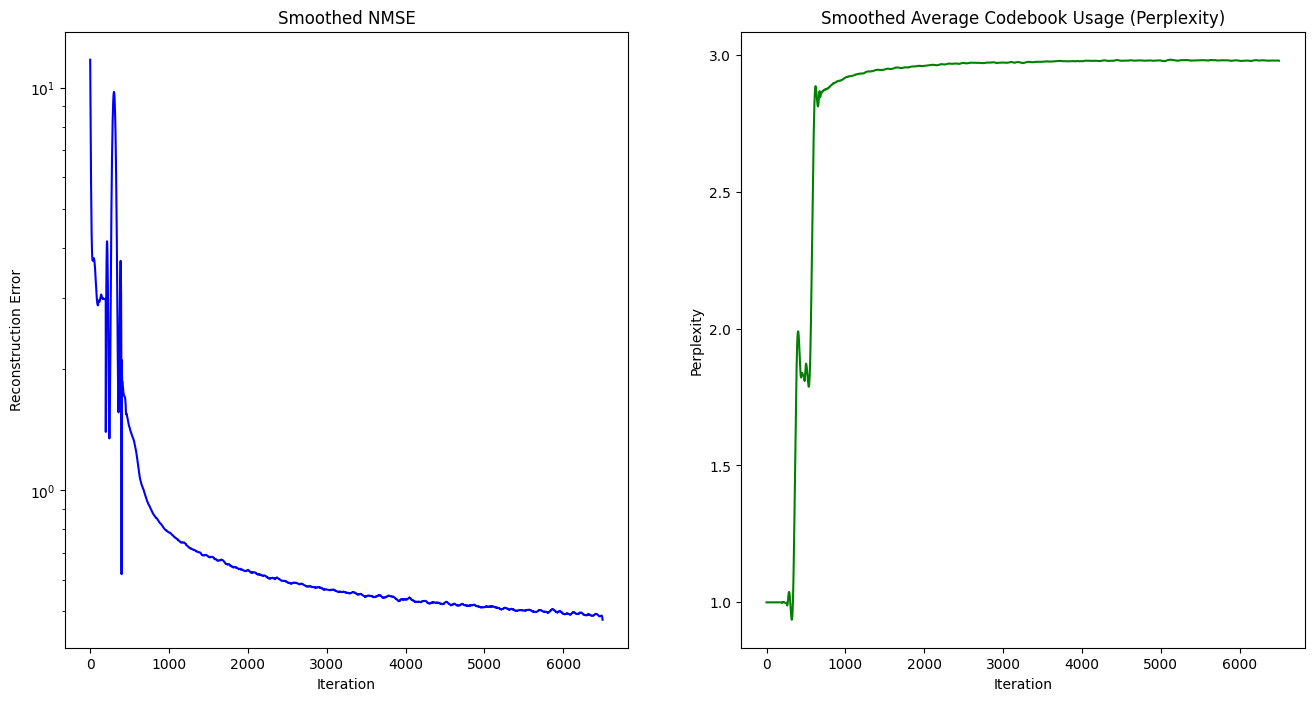

In [ ]:
# Smooth the training results
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot smoothed NMSE with color
axes[0].plot(train_res_recon_error_smooth, color='blue')
axes[0].set_yscale('log')
axes[0].set_title('Smoothed NMSE')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Reconstruction Error')

# Plot smoothed average codebook usage (perplexity) with color
axes[1].plot(train_res_perplexity_smooth, color='green')
axes[1].set_title('Smoothed Average Codebook Usage (Perplexity)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Perplexity')

plt.show()

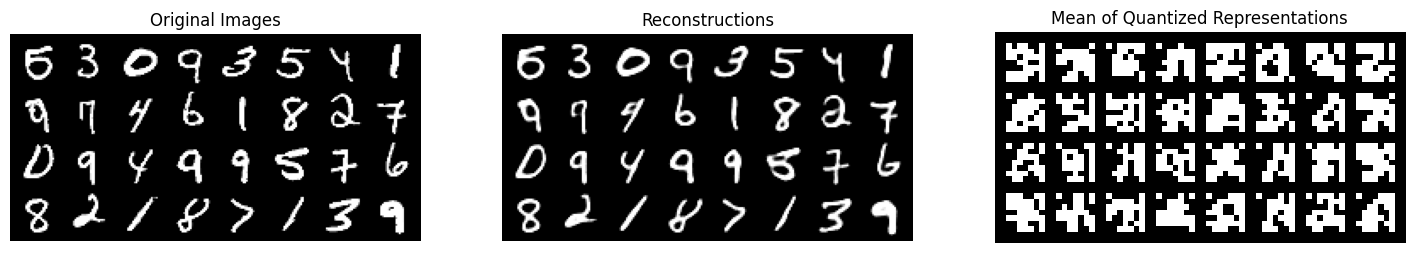

In [ ]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test data
(test_samples, _) = next(iter(test_loader))
test_samples = test_samples.to(device)

# Forward pass through the model
vq_output_eval = model.pre_vq_conv(model.encoder(test_samples))
_, test_quantize, _, _ = model.vq_vae(vq_output_eval)
test_reconstructions = model.decoder(test_quantize)
test_quantize_mean = torch.mean(test_quantize, dim=1)

# Display the reconstructions and original images
fig, axes = plt.subplots(1, 3, figsize=(18, 18))

# Display original images
axes[0].imshow(make_grid(test_samples.cpu() + 0.5).permute(1, 2, 0))
axes[0].set_title('Original Images')
axes[0].axis('off')

# Display reconstructions
axes[1].imshow(make_grid(test_reconstructions.cpu().data + 0.5).permute(1, 2, 0))
axes[1].set_title('Reconstructions')
axes[1].axis('off')

# Display the mean of quantized representations
axes[2].imshow(make_grid(test_quantize_mean.cpu()).permute(1, 2, 0))
axes[2].set_title('Mean of Quantized Representations')
axes[2].axis('off')

plt.show()

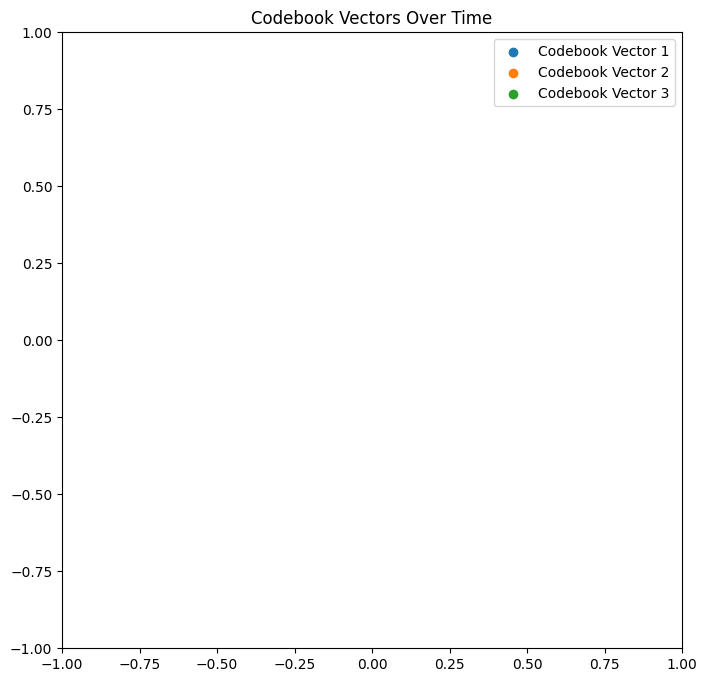

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title('Codebook Vectors Over Time')

# Initialize empty scatter plots for each codebook vector
scatter_plots = [ax.scatter([], [], label=f'Codebook Vector {i+1}') for i in range(code_book[0].shape[0])]

# Add legend
ax.legend(loc='upper right')

# Update function for the animation
def update(frame):
    for i, scatter in enumerate(scatter_plots):
        scatter.set_offsets(torch.tensor(code_book[frame][i]).to(device).cpu().numpy())
    return scatter_plots

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(code_book), blit=True)

# Save the animation as a GIF
ani.save('codebook_animation.gif', writer='imagemagick', fps=5)

In [19]:
# Define the transform for the dataset
color_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))])

# Load the MNIST dataset with the specified transform
train_dataset = datasets.MNIST(root='./data/', train=True, download=True, transform=color_transform)
test_dataset = datasets.MNIST(root='./data/', train=False, download=True, transform=color_transform)

# Create DataLoader instances for training and validation
colored_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
colored_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [23]:
### Different number of vector ###
# Set hyperparameters
num_epochs = 6000
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
data_channels = 3
embedding_dim = 2
num_embeddings_list = [30, 40, 50]
commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

# Check if a GPU is available, if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate the variance of the pixel values in the training data, normalized to the range [0, 1]
data_variance = torch.var(train_data.data.reshape(-1) / 255.0)

# Lists to store results
recon_error_by_embedding = []
perplexity_by_embedding = []
code_book_by_embedding = []

# Training loop for different numbers of codebooks
for num_embeddings in num_embeddings_list:
    # Initialize the model and optimizer
    model = VQVAEModel(data_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

    # Lists to store results for the current number of codebooks
    train_recon_error = []
    train_perplexity = []
    code_book = []

    # Training loop for each epoch
    for epoch in range(num_epochs):
        # Fetch a batch of training data
        (data, _) = next(iter(colored_train_loader))
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass and compute loss
        vq_loss, data_recon, perplexity, _ = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance
        loss = recon_error + vq_loss

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Record training statistics
        train_recon_error.append(recon_error.item())
        train_perplexity.append(perplexity.item())

        # Print progress and statistics every 50 iterations
        if (epoch + 1) % 50 == 0:
            code_book.append(model.vq_vae.embedding.weight.data.cpu().numpy())
            print(f"Iteration {epoch+1}/{num_epochs}: "
                  f"Number of Codebooks: {num_embeddings}, "
                  f"Total Loss: {loss.item():.3f}, "
                  f"Reconstruction Error: {recon_error.item():.3f}, "
                  f"VQ Loss: {vq_loss.item():.3f}, "
                  f"Perplexity: {perplexity.item():.3f}")


    # Store results for the current number of codebooks
    recon_error_by_embedding.append(train_recon_error)
    perplexity_by_embedding.append(train_perplexity)
    code_book_by_embedding.append(code_book)

Iteration 50/6000: Number of Codebooks: 30, Total Loss: 0.737, Reconstruction Error: 0.664, VQ Loss: 0.073, Perplexity: 1.590
Iteration 100/6000: Number of Codebooks: 30, Total Loss: 1.150, Reconstruction Error: 0.983, VQ Loss: 0.167, Perplexity: 2.043
Iteration 150/6000: Number of Codebooks: 30, Total Loss: 0.342, Reconstruction Error: 0.290, VQ Loss: 0.051, Perplexity: 2.566
Iteration 200/6000: Number of Codebooks: 30, Total Loss: 0.318, Reconstruction Error: 0.250, VQ Loss: 0.068, Perplexity: 2.576
Iteration 250/6000: Number of Codebooks: 30, Total Loss: 0.274, Reconstruction Error: 0.209, VQ Loss: 0.065, Perplexity: 2.647
Iteration 300/6000: Number of Codebooks: 30, Total Loss: 0.220, Reconstruction Error: 0.178, VQ Loss: 0.042, Perplexity: 3.285
Iteration 350/6000: Number of Codebooks: 30, Total Loss: 0.201, Reconstruction Error: 0.159, VQ Loss: 0.042, Perplexity: 3.300
Iteration 400/6000: Number of Codebooks: 30, Total Loss: 0.187, Reconstruction Error: 0.146, VQ Loss: 0.042, Per

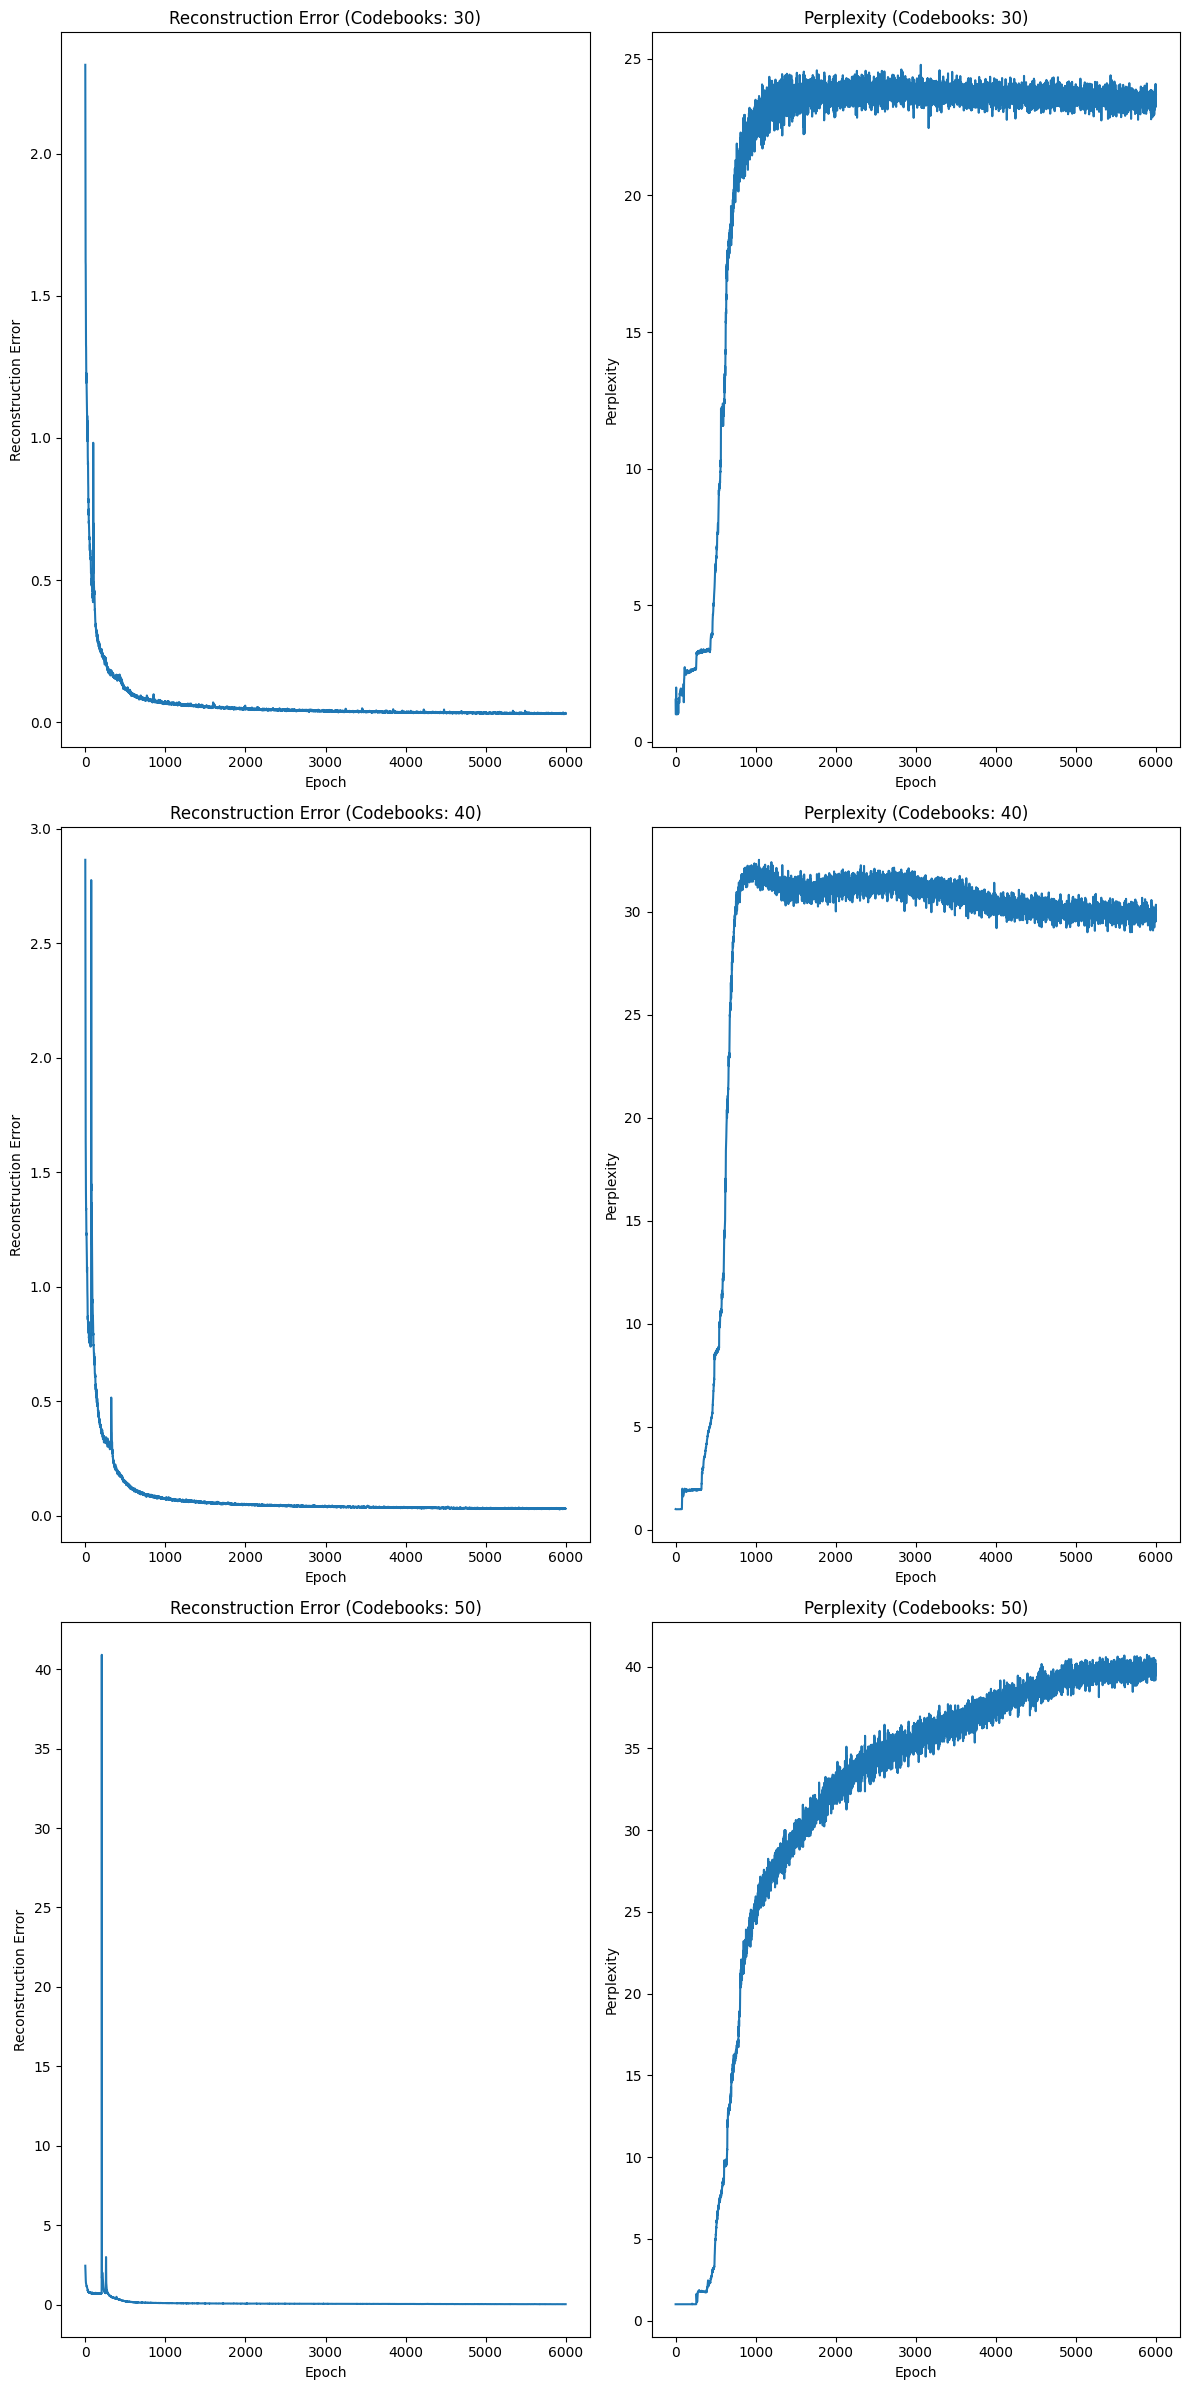

In [24]:
# Plotting
fig, axes = plt.subplots(len(num_embeddings_list), 2, figsize=(12, 8 * len(num_embeddings_list)))

for idx, num_embeddings in enumerate(num_embeddings_list):
    # Plot Reconstruction Error
    axes[idx, 0].plot(recon_error_by_embedding[idx])
    axes[idx, 0].set_title(f'Reconstruction Error (Codebooks: {num_embeddings})')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Reconstruction Error')

    # Plot Perplexity
    axes[idx, 1].plot(perplexity_by_embedding[idx])
    axes[idx, 1].set_title(f'Perplexity (Codebooks: {num_embeddings})')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Perplexity')

plt.tight_layout()
plt.show()

### Reconstruction Error:
- **Behavior Across Codebook Sizes:**
  - For each codebook size (30, 40, and 50), the left column graphs show a similar trend in the "Reconstruction Error" over increasing codebooks number.
  - There is a sharp decline in reconstruction error at the beginning of training, indicating that the model quickly improves its ability to reconstruct input data.

- **Stabilization of Reconstruction Error:**
  - The decline in reconstruction error stabilizes as training progresses, suggesting that the model reaches a point where further training does not significantly reduce the reconstruction error.
  - This stabilization could imply that the model has learned a representation of the input data that captures the essential information, and additional training steps do not result in substantial improvements in reconstruction.

### Perplexity:
- **Effect of Increasing Codebooks number:**
  - In the right column graphs, the "Perplexity" metric increases steadily over training steps for all three codebook sizes.
  - This suggests that, as the model is trained for more codebooks, its predictions become more uncertain or diverse.


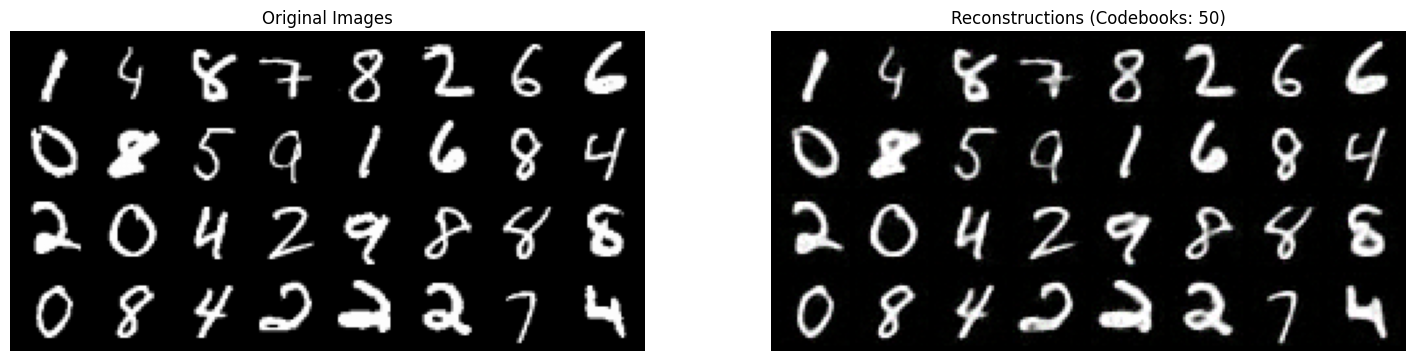

In [34]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test data
(test_samples, _) = next(iter(colored_test_loader))
test_samples = test_samples.to(device)

# Forward pass through the model
vq_output_eval = model.pre_vq_conv(model.encoder(test_samples))
_, test_quantize, _, _ = model.vq_vae(vq_output_eval)
test_reconstructions = model.decoder(test_quantize)
test_quantize_mean = torch.mean(test_quantize, dim=1)

# Display the reconstructions and original images
fig, axes = plt.subplots(1, 2, figsize=(18, 18))

# Display original images
axes[0].imshow(make_grid(test_samples.cpu() + 0.5).permute(1, 2, 0))
axes[0].set_title('Original Images')
axes[0].axis('off')

# Display reconstructions
axes[1].imshow(make_grid(test_reconstructions.cpu().data + 0.5).permute(1, 2, 0))
axes[1].set_title(f'Reconstructions (Codebooks: {num_embeddings})')
axes[1].axis('off')

plt.show()

In [39]:
# Set hyperparameters
num_training_updates = 6000
num_hiddens = 128
num_residual_hiddens = 24
num_residual_layers = 2
data_channels = 3
embedding_dim_list = [20, 30]
num_embeddings = 3
commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

# Lists to store results for different embedding dimensions
embedding_dim_results = []

# Train the model for different embedding dimensions
for embedding_dim in embedding_dim_list:
    model = VQVAEModel(data_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
    model.train()

    # Lists to store results for each iteration
    iteration_results = {'recon_error': [], 'vq_loss': [], 'perplexity': [], 'code_book': []}

    for i in range(num_training_updates):
        (data, _) = next(iter(colored_train_loader))
        data = data.to(device)
        optimizer.zero_grad()
        vq_loss, data_recon, perplexity, _ = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()

        iteration_results['recon_error'].append(recon_error.item())
        iteration_results['vq_loss'].append(vq_loss.item())
        iteration_results['perplexity'].append(perplexity.item())

        if (i + 1) % 50 == 0:
            iteration_results['code_book'].append(model.vq_vae.embedding.weight.data.cpu().numpy())
            print(f'Embedding Dim: {embedding_dim}, Iteration {i+1}/{num_training_updates}, '
                  f'Total Loss: {loss.item():.3f}, '
                  f'Recon Error: {recon_error.item():.3f}, '
                  f'VQ Loss: {vq_loss.item():.3f}, '
                  f'Perplexity: {perplexity.item():.3f}')

    # Append results for the current embedding dimension to the main list
    embedding_dim_results.append(iteration_results)

Embedding Dim: 20, Iteration 50/6000, Total Loss: 1.065, Recon Error: 1.063, VQ Loss: 0.001, Perplexity: 1.000
Embedding Dim: 20, Iteration 100/6000, Total Loss: 0.648, Recon Error: 0.622, VQ Loss: 0.026, Perplexity: 1.775
Embedding Dim: 20, Iteration 150/6000, Total Loss: 0.591, Recon Error: 0.458, VQ Loss: 0.133, Perplexity: 1.700
Embedding Dim: 20, Iteration 200/6000, Total Loss: 0.619, Recon Error: 0.361, VQ Loss: 0.258, Perplexity: 1.750
Embedding Dim: 20, Iteration 250/6000, Total Loss: 0.559, Recon Error: 0.323, VQ Loss: 0.236, Perplexity: 1.775
Embedding Dim: 20, Iteration 300/6000, Total Loss: 0.583, Recon Error: 0.311, VQ Loss: 0.272, Perplexity: 1.846
Embedding Dim: 20, Iteration 350/6000, Total Loss: 0.575, Recon Error: 0.307, VQ Loss: 0.268, Perplexity: 1.864
Embedding Dim: 20, Iteration 400/6000, Total Loss: 0.626, Recon Error: 0.289, VQ Loss: 0.337, Perplexity: 1.799
Embedding Dim: 20, Iteration 450/6000, Total Loss: 0.632, Recon Error: 0.301, VQ Loss: 0.332, Perplexity:

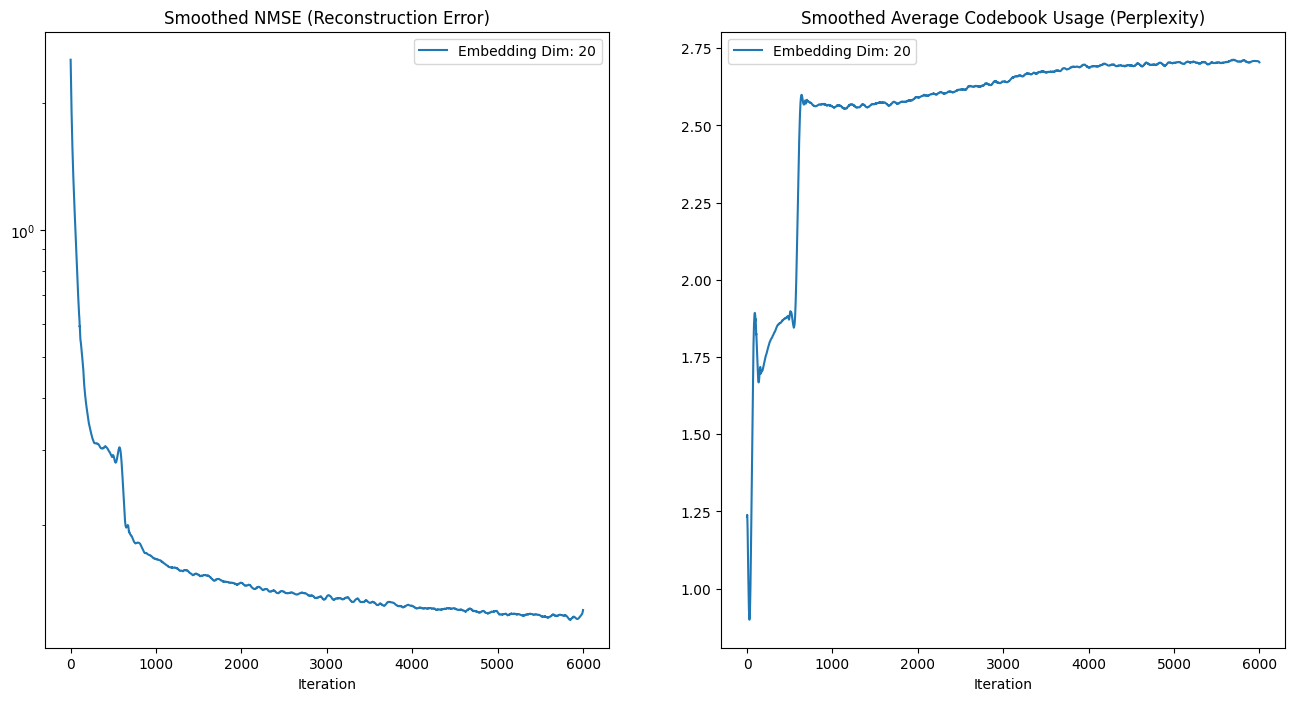

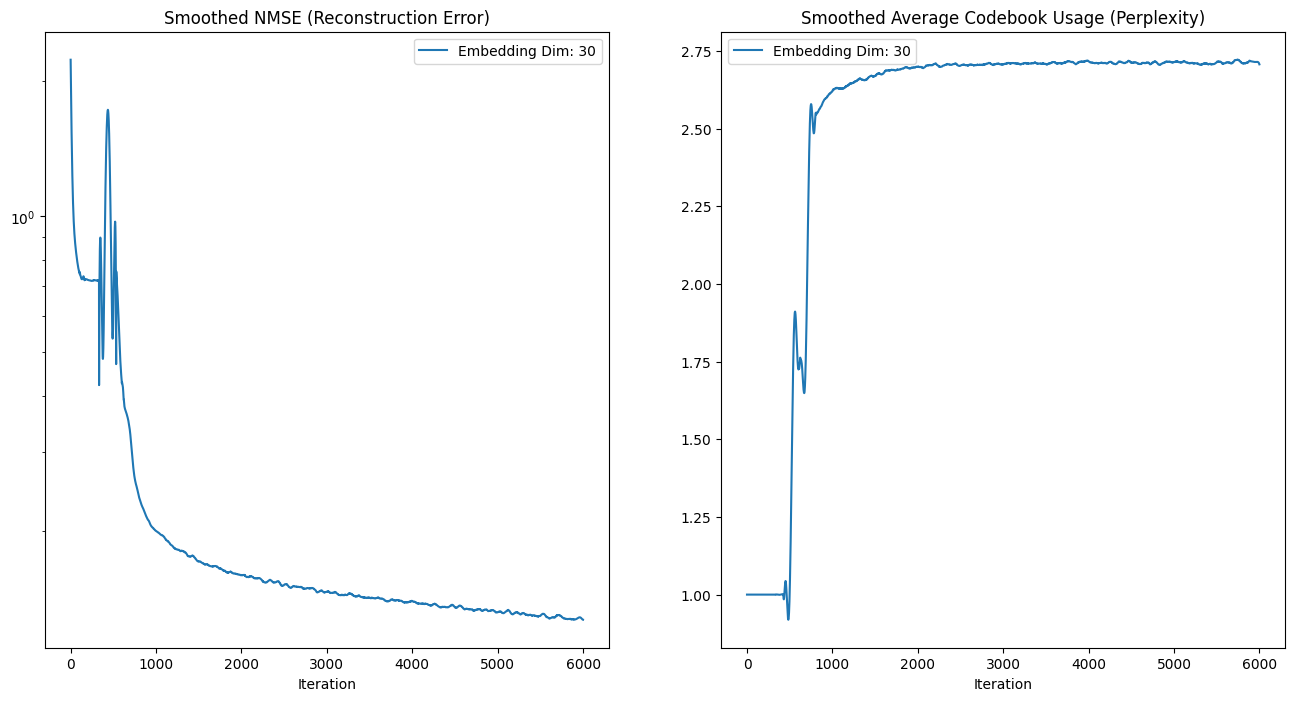

In [40]:
# Plotting for different embedding dimensions
for idx, embedding_dim_result in enumerate(embedding_dim_results):
    # Smooth the recon_error and perplexity curves
    recon_error_smooth = savgol_filter(embedding_dim_result['recon_error'], 201, 7)
    perplexity_smooth = savgol_filter(embedding_dim_result['perplexity'], 201, 7)

    # Create a figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot smoothed NMSE (Reconstruction Error)
    axes[0].plot(recon_error_smooth, label=f'Embedding Dim: {embedding_dim_list[idx]}')
    axes[0].set_yscale('log')
    axes[0].set_title('Smoothed NMSE (Reconstruction Error)')
    axes[0].set_xlabel('Iteration')
    axes[0].legend()

    # Plot smoothed Average codebook usage (Perplexity)
    axes[1].plot(perplexity_smooth, label=f'Embedding Dim: {embedding_dim_list[idx]}')
    axes[1].set_title('Smoothed Average Codebook Usage (Perplexity)')
    axes[1].set_xlabel('Iteration')
    axes[1].legend()

    plt.show()


### Compare Embedding Dimension

- The embedding dimension has increased from 20 to 30. This could mean that the model or algorithm is now using a higher-dimensional space for its computations.
- The reconstruction error and perplexity trends appear to be similar, but without the exact values, it's hard to make a precise comparison. However, the general trend of decreasing error and increasing perplexity over iterations seems to be consistent.

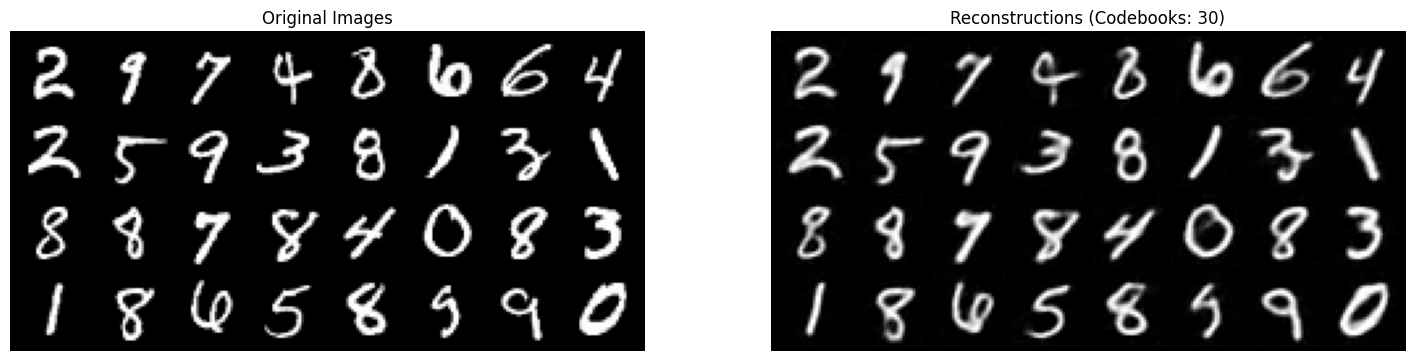

In [42]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test data
(test_samples, _) = next(iter(colored_test_loader))
test_samples = test_samples.to(device)

# Forward pass through the model
vq_output_eval = model.pre_vq_conv(model.encoder(test_samples))
_, test_quantize, _, _ = model.vq_vae(vq_output_eval)
test_reconstructions = model.decoder(test_quantize)
test_quantize_mean = torch.mean(test_quantize, dim=1)

# Display the reconstructions and original images
fig, axes = plt.subplots(1, 2, figsize=(18, 18))

# Display original images
axes[0].imshow(make_grid(test_samples.cpu() + 0.5).permute(1, 2, 0))
axes[0].set_title('Original Images')
axes[0].axis('off')

# Display reconstructions
axes[1].imshow(make_grid(test_reconstructions.cpu().data + 0.5).permute(1, 2, 0))
axes[1].set_title(f'Reconstructions (Codebooks: {embedding_dim})')
axes[1].axis('off')

plt.show()
